# Data Load

In [45]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt


# Combine Datasets

In [46]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773

    # Shuffle indices of data
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    # Sizes of the train, test, val
    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size

    # Chosing indices for splitting
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    # Choosing subsets according to indices
    #Therefore we can split data randomly
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [47]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [48]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.3, patch_size = 16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob  # Probability of the masking an image
        self.patch_size = patch_size       
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]

        image = self.transform(image)

        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        _, height, width = image.shape

        # Calculate the number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        

        # An array shape like image
        # True for positions of the mask
        # False for rest of the array
        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size,  (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size,  (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[i * num_patches_w + j] = True
                    
        return masked_image, mask
    


In [49]:
dataset1 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\celeba",
)

dataset2 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\places",
)
random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

combined_dataset = ConcatDataset([custom_data1, custom_data2])


train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Example of Mask

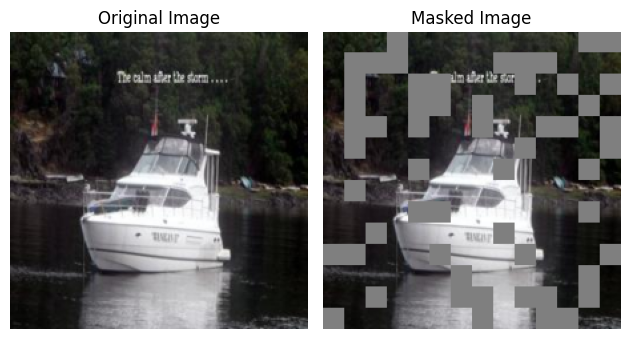

In [50]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

original_image, masked_image, mask = train_dataset[random.randint(0,2000)]  

plt.figure()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()


# Transformer

In [51]:
from transformers import ViTForMaskedImageModeling, ViTForImageClassification
from transformers import ViTConfig
from tqdm import tqdm

In [58]:
config = ViTConfig(image_size=224, patch_size=16, hidden_size=768, num_hidden_layers=4, num_attention_heads=4)
model = ViTForMaskedImageModeling.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

for param in model.parameters():
    param.requires_grad = False

for param in model.vit.encoder.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of ViTForMaskedImageModeling were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['decoder.0.bias', 'decoder.0.weight', 'embeddings.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForMaskedImageModeling(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-3): 4 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_feat

In [59]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10, device="cuda"):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):  
        running_loss = 0.0
        for images, masked_images, masks in tqdm(dataloader):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            # Forward pass
            outputs = model(masked_images, bool_masked_pos=masks).logits  
            loss = criterion(outputs, images)  

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

train_model(model, train_loader, criterion, optimizer)

  0%|          | 11/6639 [01:02<10:29:14,  5.70s/it]


KeyboardInterrupt: 